# Feature weighted clustering

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import importlib

import clustering, utilities, recs_preprocessing

importlib.reload(clustering)
importlib.reload(utilities)
importlib.reload(recs_preprocessing)

from utilities import KWH2BTU, BTU2KWH, SQF2SQM, SQM2SQF, THM2BTU, BTU2THM
from recs_preprocessing import Codebook, df_computed
from clustering import cluster_evaluation_subset, evaluate_gmm, evaluate_gmm_weighted, evaluate_lightgbm
from clustering import automatic_preprocess_columns, select_subset

def energy_loads_features():
    categorical_columns = []
    continuous_columns = [
        'RC_equipment_power_density', 'RC_gas_power_density', 'RC_DHW_elec_power_density',
        'RC_DHW_gas_power_density', 'RC_lighting_power_density']
    return categorical_columns, continuous_columns

def construction_features():
    categorical_columns = [
        'CELLAR', 'CRAWL', 'CONCRETE', 'BASEOTH', 'BASEFIN', 'ATTIC',
        'ATTICFIN', 'WALLTYPE', 'ROOFTYPE', 'ADQINSUL', 'TYPEGLASS', 'WINFRAME']
    continuous_columns = [
        'eui_kwh_elec_thermal', 'eui_btu_ng_thermal', 'eui_btu_ofuel_thermal', 'window_per_sqm', 'door_per_sqm'
    ]
    return categorical_columns, continuous_columns

def systems_features():
    # systems
    categorical_columns = [
        'EQUIPM', 'FUELHEAT', 'BASEHEAT', 'GARGHEAT', 'ATTCHEAT', 'GEOHP',
        'AIRCOND', 'COOLAPT', 'ACEQUIPM_PUB', 'BASECOOL', 'ATTCCOOL', 'GARGCOOL', 'EQUIPAGE', 'ACEQUIPAGE'
    ] # systems -> heating and cooling system
    continuous_columns = [
        'eui_kwh_elec_sph', 'eui_btu_ng_sph', 'eui_btu_ofuel_sph',
        'eui_kwh_elec_col', 'eui_kwh_elec_latent'
    ]
    return categorical_columns, continuous_columns


In [6]:
categorical_columns, continuous_columns = construction_features()
subset_criteria = {'IECC_climate_code': '5A', 'TYPEHUQ': 2}
subset = select_subset(df_computed, by=subset_criteria)
da = df_computed.loc[subset.index][categorical_columns + continuous_columns + ['NWEIGHT']].copy()

In [9]:
data, _cat_indices, _preprocessor, _weights = automatic_preprocess_columns(da, cols_cat=categorical_columns, cols_con=continuous_columns)

In [84]:
data

,eui_kwh_elec_thermal,eui_btu_ng_thermal,eui_btu_ofuel_thermal,window_per_sqm,door_per_sqm,CELLAR_1,CRAWL_1,CONCRETE_1,BASEOTH_1,BASEFIN_1,...,ADQINSUL_3,ADQINSUL_4,TYPEGLASS_2,TYPEGLASS_3,WINFRAME_2,WINFRAME_3,WINFRAME_4,WINFRAME_5,ADQINSUL,TYPEGLASS
DOEID,,,,,,,,,,,,,,,,,,,,,
100017,-0.615708,-1.023799,1.009852,1.906995,1.856530,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.5
100024,0.119108,-1.023799,-0.527954,-1.627185,0.489366,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.5
100025,-0.088916,2.580075,-0.527954,-0.487405,-0.784432,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.5
100026,-0.363570,-1.023799,0.753476,1.461081,1.291386,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.5
100028,-0.190553,-1.023799,1.229807,3.083809,-0.784432,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118436,-0.306613,0.222401,-0.527954,-1.210727,-0.784432,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.666667,0.0
118443,-0.484937,-1.023799,0.810926,-0.522732,0.149686,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.333333,0.5
118460,-0.419405,0.218230,-0.527954,-1.011376,-0.784432,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.5


In [85]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
X = da[categorical_columns]
y = data[continuous_columns]

# Encode categoricals numerically
X_encoded = pd.get_dummies(X.astype('category'), drop_first=True)
X_full = pd.concat([X_encoded, y], axis=1)
is_categorical = np.array([col in X_encoded.columns for col in X_full.columns])
mi_scores = []
for col in X_full.columns:
    y = X_full[col]
    if col in X_encoded.columns:
        mi_score = mutual_info_classif(X_full, y, discrete_features=is_categorical)
    else:
        mi_score = mutual_info_regression(X_full, y, discrete_features=~is_categorical)
    mi_scores.append(mi_score)

<Axes: >

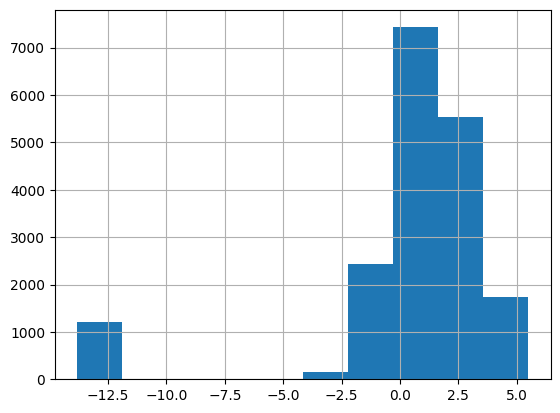

In [ ]:
df_computed['eui_kwh_elec_thermal'].apply(lambda x: np.log(x+1e-6)).hist()

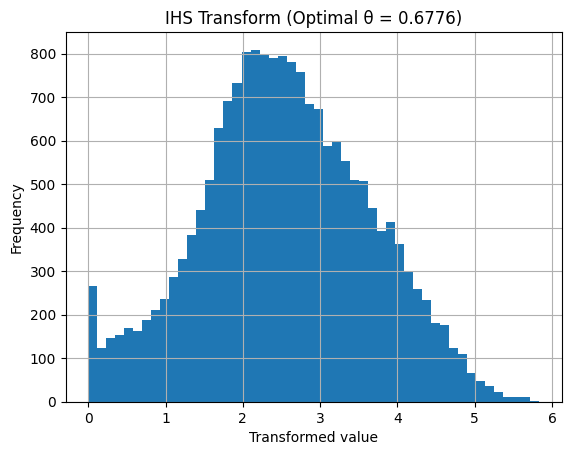

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.optimize import minimize_scalar

# Data: can be positive, zero, or negative
x = df_computed['eui_kwh_elec_thermal'].dropna().values

# Objective: minimize skewness of transformed data
def ihs_skew(theta):
    transformed = np.arcsinh(theta * x)
    return abs(skew(transformed))  # absolute skewness

# Fit theta using bounded minimization
result = minimize_scalar(ihs_skew, bounds=(-1, 10), method='bounded')
theta_opt = result.x

# Apply optimal IHS transform
df_computed['eui_kwh_elec_thermal_ihs'] = np.arcsinh(theta_opt * df_computed['eui_kwh_elec_thermal'])

# Plot result
df_computed['eui_kwh_elec_thermal_ihs'].hist(bins=50)
plt.title(f'IHS Transform (Optimal θ = {theta_opt:.4f})')
plt.xlabel('Transformed value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


<Axes: >

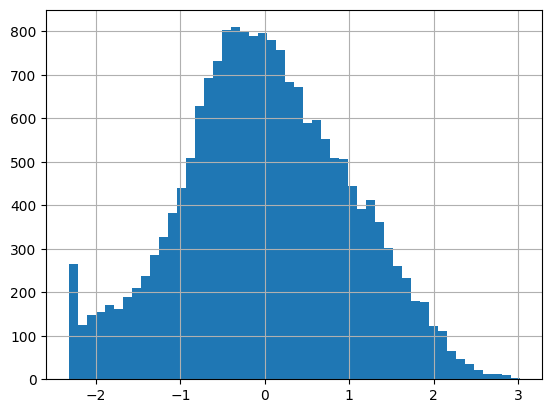

In [141]:
standard = (df_computed['eui_kwh_elec_thermal_ihs'] - df_computed['eui_kwh_elec_thermal_ihs'].mean()) / df_computed['eui_kwh_elec_thermal_ihs'].std()
standard.hist(bins=50)

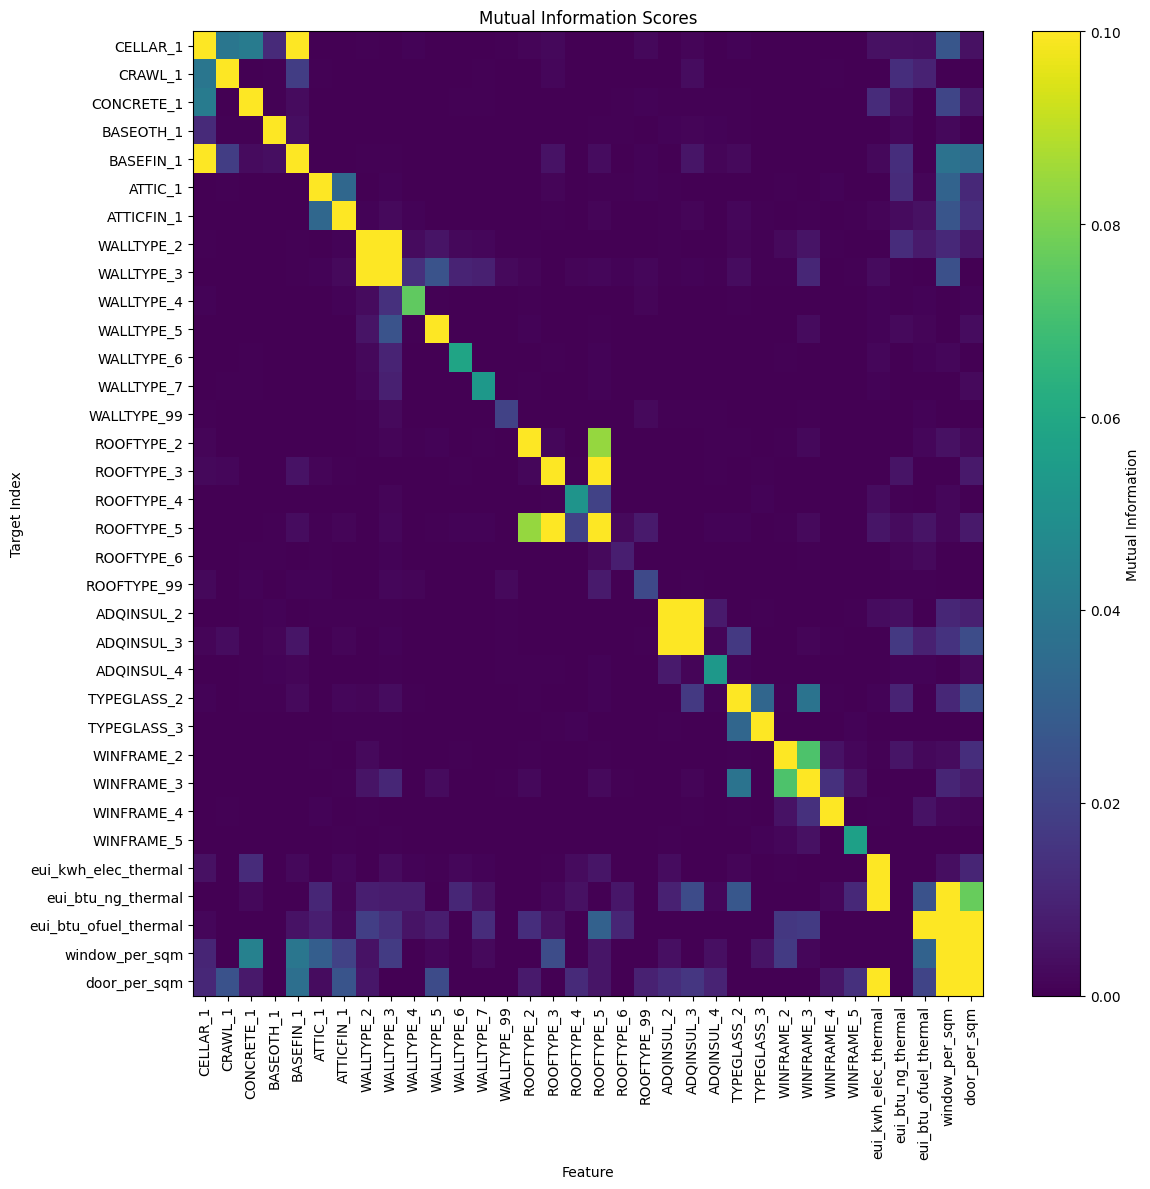

In [86]:
plt.figure(figsize=(12, 12))
plt.imshow(mi_scores, aspect='auto', cmap='viridis', vmax=0.1)
plt.colorbar(label='Mutual Information')
plt.title('Mutual Information Scores')
plt.xlabel('Feature')
plt.ylabel('Target Index')
plt.xticks(ticks=np.arange(len(X_full.columns)), labels=X_full.columns, rotation=90)
plt.yticks(ticks=np.arange(len(X_full.columns)), labels=X_full.columns)
plt.tight_layout()
plt.show()

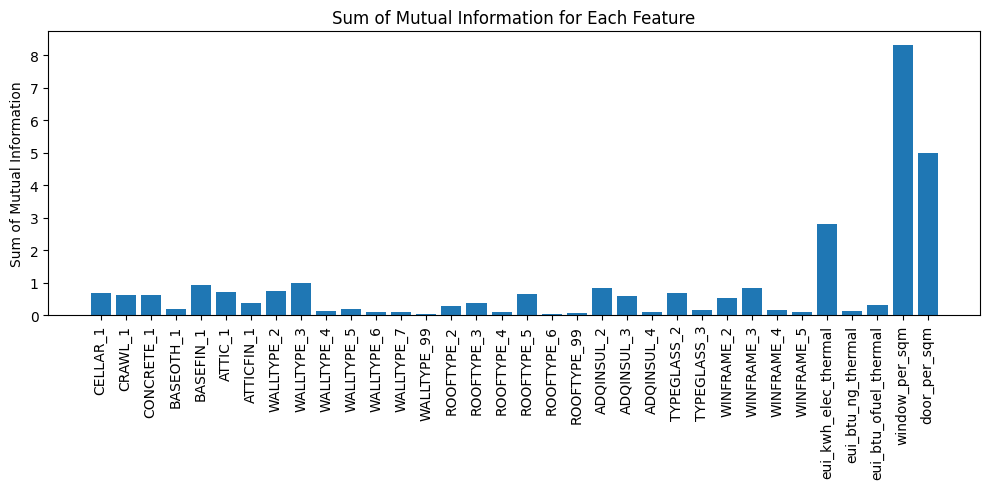

In [89]:
mi_sum = np.sum(mi_scores, axis=0)
plt.figure(figsize=(10, 5))
plt.bar(range(len(X_full.columns)), mi_sum)
plt.xticks(ticks=np.arange(len(X_full.columns)), labels=X_full.columns, rotation=90)
plt.ylabel('Sum of Mutual Information')
plt.title('Sum of Mutual Information for Each Feature')
plt.tight_layout()
plt.show()

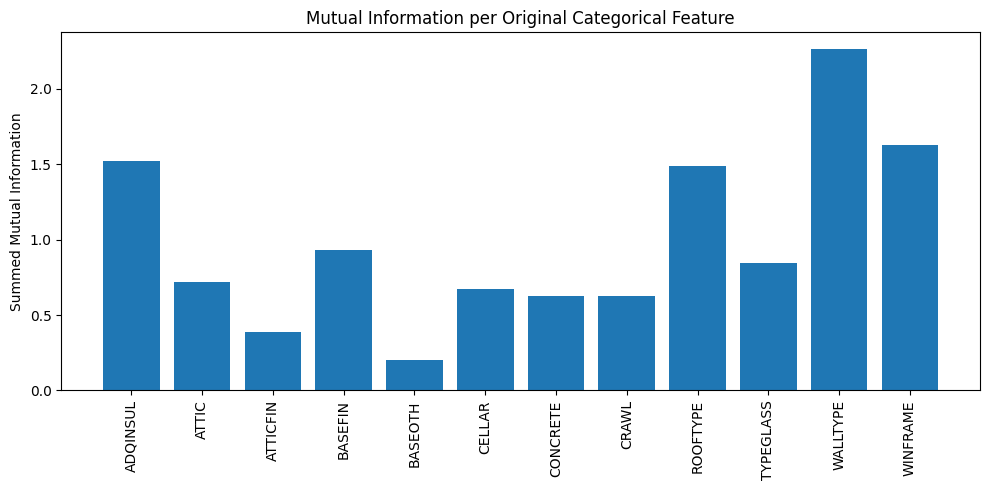

In [92]:

# Create a mapping from one-hot column back to original feature
dummy_map = {}
for col in X.columns:
    categories = pd.get_dummies(X[col].astype('category'), prefix=col, drop_first=True).columns
    for cat in categories:
        dummy_map[cat] = col

# Create a DataFrame to store mutual information scores
mi_df = pd.DataFrame({
    'feature': X_encoded.columns,
    'original_feature': [dummy_map[col] for col in X_encoded.columns],
    'mi_sum': mi_sum[:len(X_encoded.columns)]  # only the one-hot part
})

# Sum MI per original feature
mi_aggregated = mi_df.groupby('original_feature')['mi_sum'].sum()#.sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(mi_aggregated.index, mi_aggregated.values)
plt.xticks(rotation=90)
plt.ylabel("Summed Mutual Information")
plt.title("Mutual Information per Original Categorical Feature")
plt.tight_layout()
plt.show()
